# Определение возраста покупателей

<br>Описание проекта<br>
<b>Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [ ]:
# < Перенесите сюда исследовательский анализ данных >
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

Found 7591 validated image filenames.


<AxesSubplot:>

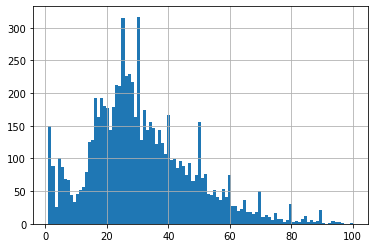

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

labels['real_age'].hist(bins=100)

In [ ]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


(32, 224, 224, 3)


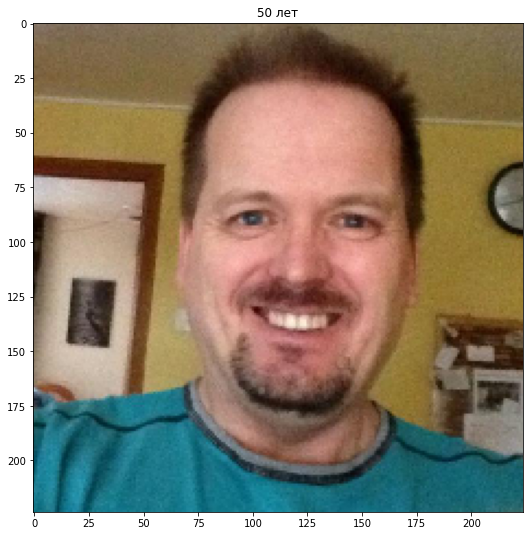

(32, 224, 224, 3)


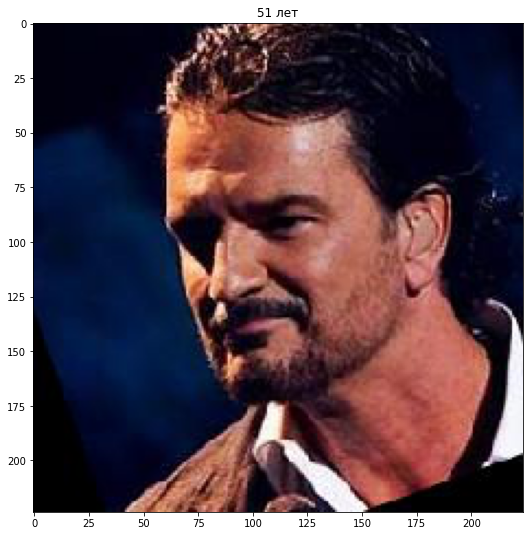

(32, 224, 224, 3)


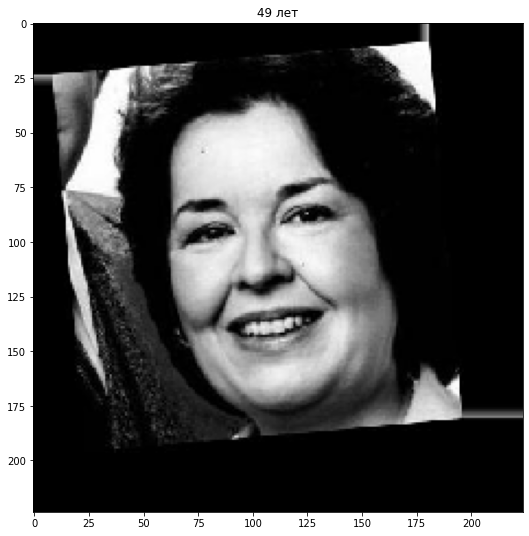

(32, 224, 224, 3)


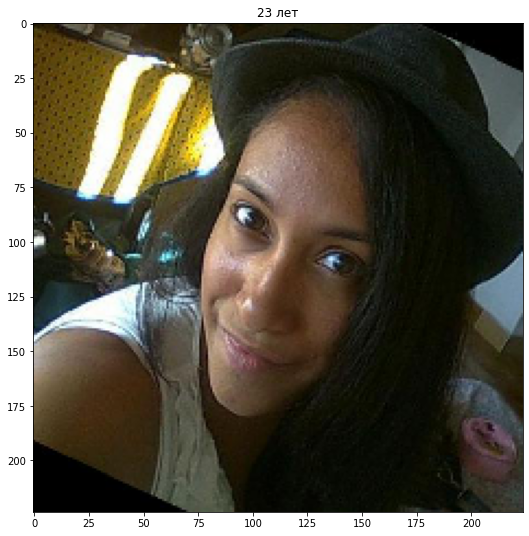

(32, 224, 224, 3)


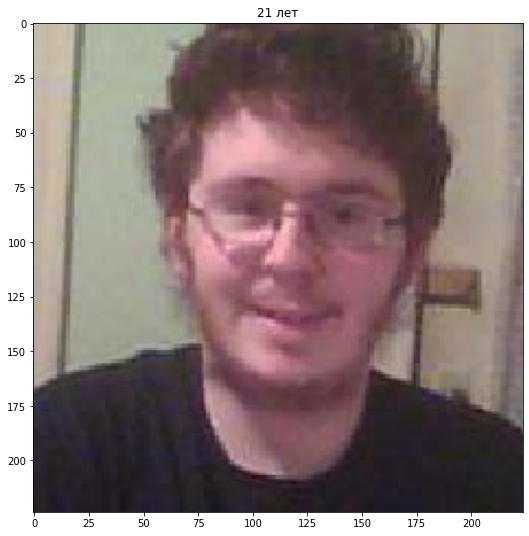

(32, 224, 224, 3)


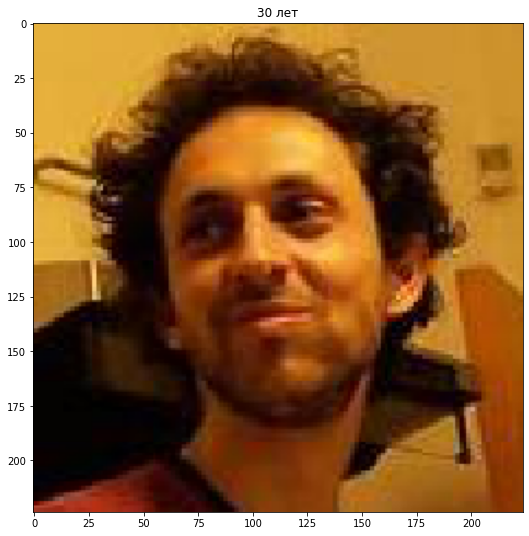

(32, 224, 224, 3)


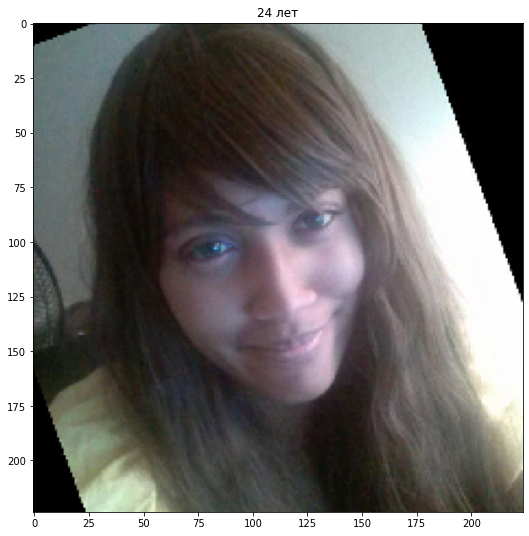

(32, 224, 224, 3)


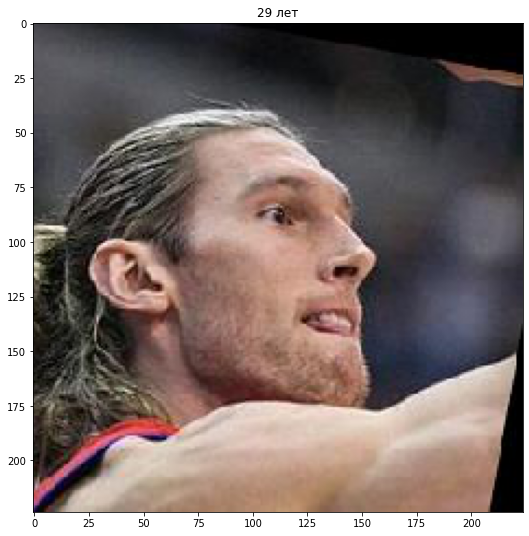

(32, 224, 224, 3)


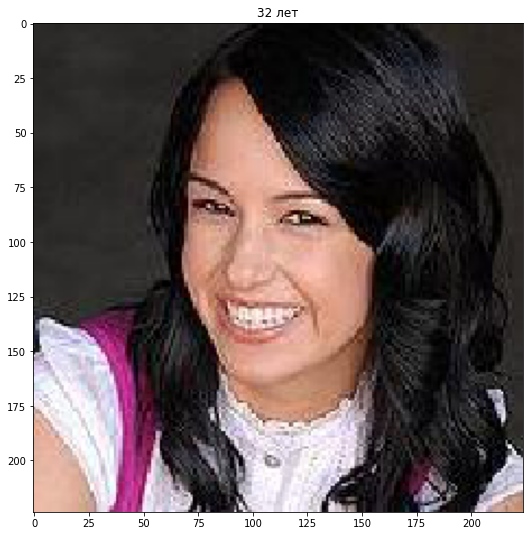

(32, 224, 224, 3)


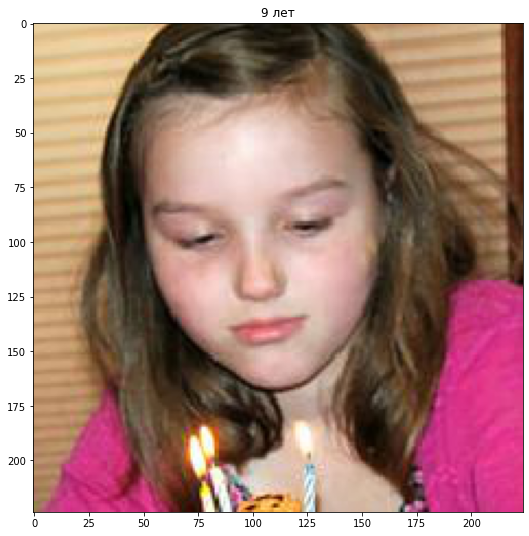

<Figure size 648x648 with 0 Axes>

In [ ]:
plt.rcParams['figure.figsize'] = (9,9)
for _ in range(10):
    
    img, label = train_gen_flow.next()
    print(img.shape)   #  (1,256,256,3)
    plt.title(str(label[0])+' лет')
    plt.imshow(img[0])
    plt.show()
plt.tight_layout()

Большое кол-во фото в возрасте 25-30. 7591 объектов. Есть черно белые фото а так же фото перевёрнутые. Есть так же фото низкого качества. Какое точное соотношение сказать сложно, в любом случае чем больше данных тем лучше. Селфи напарсить в инстаграмме не так сложно.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):
    df = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,rescale=1 / 255)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe =df,
        directory=path+'final_files/',
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345,
        subset='training')
    return train_datagen_flow

def load_test(path):
    df = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,rescale=1 / 255)
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe =df,
        directory=path+'final_files/',
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=16,
        subset = 'validation',
        class_mode='raw',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    #optimizer = Adam(lr=0.0002)
    backbone = ResNet50(input_shape =(224, 224,3),
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)

    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())

    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0002)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    model.summary()
    return model


def train_model(model,  train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/5
2022-09-19 13:28:21.975590: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-19 13:28:22.287757: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 68s - loss: 10.5628 - mae: 10.5636 - val_loss: 14.7955 - val_mae: 14.7867
Epoch 2/5
356/356 - 43s - loss: 7.7407 - mae: 7.7408 - val_loss: 13.2310 - val_mae: 13.2205
Epoch 3/5
356/356 - 44s - loss: 6.7433 - mae: 6.7430 - val_loss: 8.1813 - val_mae: 8.1826
Epoch 4/5
356/356 - 44s - loss: 6.0266 - mae: 6.0260 - val_loss: 9.6028 - val_mae: 9.6086
Epoch 5/5
356/356 - 43s - loss: 5.3448 - mae: 5.3452 - val_loss: 6.8403 - val_mae: 6.8389
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 6.8403 - mae: 6.8389
Test MAE: 6.8389

```

## Анализ обученной модели

<br><b>Параметры модели</b>
<br>Архитектура ResNet50
<br>learning rate = 0.0002
<br>5 эпох
<br>1 нейрон.

"Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы" - C этой задачей модель может справиться. Достачно будет того что бы предсказаный возраст попадал в определенную возрастную группу.

Контролировать добросовестность кассиров при продаже алкоголя. - Вполне вероятно для этой задачи эту модель можно использовать. Только имхо я бы применил двойную валидацию либо постарался уменьшить ещё больше mse. В любом случае для выполнения определения добросовестности нужно чтоб человек показывал документы, а дальше уже можно смотреть результаты модели.

По хорошему нужно уменьшить распределение возрастов стремится сделать его ровным. Тогда качество модели будет выше. Т.к данных для некоторых диапазонов недостаточно, короче говоря дисбаланс классов. Условия проекта выполняются.

<B>Итоговое MAE = 6.8389

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы